In [1]:
# v5: change hadcrut to C&W

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np
import xarray as xr
import os
import glob
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import scipy.stats as stats

def make_df(path):
    all_files = glob.glob(os.path.join(path, "*.csv"))
    df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
    return df

def get_baseline(df, t_bnds=[1850, 1900], monthly=False, multi_ens=False):
    df_hist = df[df['Experiment']=='historical']
    
    df_hist = df_hist[(df_hist['year'] > t_bnds[0]) & (df_hist['year'] < t_bnds[1])]
    
    df_hist['base_t_bnds'] = str(t_bnds[0]) + '-' + str(t_bnds[1])
    if monthly:
        df_hist = df_hist.groupby(['Model', 'base_t_bnds', 'Month']).mean().reset_index().rename(columns=baseline_name_changes)
    else:
        if multi_ens:
            df_hist = df_hist.groupby(['Model', 'Ensemble_member', 'base_t_bnds']).mean().reset_index().rename(columns=baseline_name_changes)
        else:
            df_hist = df_hist.groupby(['Model', 'base_t_bnds']).mean().reset_index().rename(columns=baseline_name_changes)
    df_hist = df_hist.drop(columns=['year'])
    return df_hist

def wmean(df, values, weights):
    return sum(df[weights]*df[values])/df[weights].sum()

def preprocess_hadcrut_z(df, window, preind_period=[1850,1900]):
    """ hadcrut analysis annual means tas data is donwloaded as anomaly relative to the period 
        1961-1990, (see description here: https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/download.html)
        we preprocess by re-baselining this to be anomaly relative to our preindustrial period, 1850-1900""
    
    returns df with tas relative to pre-industrial mean """
    df.rename(columns={'Time':'Year'}, inplace=True)
    df_pre_ind = df[df['Year'].between(preind_period[0], preind_period[1])]
    offset = df_pre_ind['Anomaly (deg C)'].mean()
    df_out = df[['Year', 'Anomaly (deg C)']]
    df_out['Anomaly (deg C)'] = df_out['Anomaly (deg C)'] - offset
    df_out['Anomaly (deg C)'] = df_out['Anomaly (deg C)'].rolling(window, center=True).mean()
    return df_out

def preprocess_obs(df, window, preind_period=[1850,1900]):
    """ hadcrut analysis annual means tas data is donwloaded as anomaly relative to the period 
        1961-1990, (see description here: https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/download.html)
        we preprocess by re-baselining this to be anomaly relative to our preindustrial period, 1850-1900""
    
    returns df with tas relative to pre-industrial mean """
    #df.rename(columns={'Time':'Year'}, inplace=True)
    df_pre_ind = df[df['year'].between(preind_period[0], preind_period[1])]
    offset_w = df_pre_ind['world_tas'].mean()
    offset_na = df_pre_ind['no_arctic_tas'].mean()
    df_out = df.copy()
    df_out['world_tas'] = df_out['world_tas'] - offset_w
    df_out['no_arctic_tas'] = df_out['no_arctic_tas'] - offset_na
    df_out['world_tas'] = df_out['world_tas'].rolling(window, center=True).mean()
    df_out['no_arctic_tas'] = df_out['no_arctic_tas'].rolling(window, center=True).mean()
    return df_out

In [2]:
### set up and read in temp data

out_dfs = {}

## models
baseline_name_changes = {'no_arctic_tas':'no_arctic_base_tas',
                         'world_tas':'world_base_tas',
                        }
window=10

# exp='ssp370'
# exp='ssp245'
exp='ssp126'

## observations
CW_file = 'int_outputs/temperature_CW/CW_tas.csv'

Obs_df = preprocess_obs(pd.read_csv(CW_file), window=window)
obs_set = 'Cowtan & Way'


### initial processing, add baseline temp to each model, 
### only keep those models with a historic scenario available
### define one tas_df used for both plots, this contains all ensemble members

in_folder_tas = 'int_outputs/temperature_multi_ens/'

tas_df = make_df(in_folder_tas)
tas_df = tas_df[tas_df['Experiment'].isin(['historical', exp])]

tas_df = tas_df.groupby(['year', 'Experiment', 'Model', 'Ensemble_member']).mean().reset_index() 

base_tas_df = get_baseline(tas_df, [1850, 1900], multi_ens=True)

tas_df = pd.merge(tas_df, base_tas_df, how='left', on=['Model', 'Ensemble_member'])
tas_df['no_arctic_tas_anom'] = tas_df['no_arctic_tas'] - tas_df['no_arctic_base_tas']
tas_df['world_tas_anom'] = tas_df['world_tas'] - tas_df['world_base_tas']

models = tas_df[tas_df['Experiment']==exp]['Model'].unique()
tas_df = tas_df[tas_df['Model'].isin(models)]
tas_df = tas_df.dropna()

models = tas_df['Model'].unique()
print(len(models))


45


In [3]:

### define a first ensemble member version of tas_df

# this (somewhat hacky) code tries ensemble members in the order below ...
# to see what label the first member for each model has
member_labels_to_try = ['r1i1p1f1', 'r2i1p1f1', 'r1i1p2f1', 'r1i1p1f2', 'r1i2p1f1', 'r1i1p1f3', 'r4i1p1f1']

tas_df_1st_mem = tas_df[tas_df['Ensemble_member']==member_labels_to_try[0]]
for model in models:
    df_test =  tas_df_1st_mem[tas_df_1st_mem['Model']==model]
    if not exp in df_test['Experiment'].unique() or not 'historical' in df_test['Experiment'].unique():
        tas_df_1st_mem.drop(tas_df_1st_mem[tas_df_1st_mem['Model']==model].index, inplace=True)
models_1st_mem = tas_df_1st_mem['Model'].unique()
remaining_models = set(models).difference(models_1st_mem)
print(len(remaining_models))

i=1
for i in range(1,len(member_labels_to_try)):    
    df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]
    tas_df_1st_mem = pd.concat([tas_df_1st_mem, df_to_append])

    for model in models:
        df_test =  tas_df_1st_mem[tas_df_1st_mem['Model']==model]
        if not exp in df_test['Experiment'].unique() or not 'historical' in df_test['Experiment'].unique():
            tas_df_1st_mem.drop(tas_df_1st_mem[tas_df_1st_mem['Model']==model].index, inplace=True)

    models_1st_mem = tas_df_1st_mem['Model'].unique()
    remaining_models = set(models).difference(models_1st_mem)

    print(len(remaining_models))
    i=i+1
#print(remaining_models)
print(len(tas_df_1st_mem['Model'].unique()))
print(len(tas_df_1st_mem[tas_df_1st_mem['year']==1850]))

12
12
11
3
3
1


/tmp/ipykernel_49027/4258750893.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]


0
45
45


In [4]:
### drop model E3SM-1-1 as the run only goes to 2024
for model in models:
    df_test = tas_df_1st_mem[tas_df_1st_mem['Model']==model]
    #print(df_test.year.max())
    if df_test.year.max() < 2099:
        print(model)
        tas_df_1st_mem.drop(tas_df_1st_mem[tas_df_1st_mem['Model']==model].index, inplace=True)

### drop ensemble members which only have a historical run from tas_df
print(len(tas_df))
for model in models:
    for ens in tas_df[tas_df['Model']==model]['Ensemble_member'].unique():
        df_test = tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens]
        if not exp in df_test['Experiment'].unique():
            #print(model+ens+'  no ssp245')
            tas_df.drop(tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens].index, inplace=True)
print(len(tas_df))

### check whether any ensemble members are incomplete
for model in models:
    for ens in tas_df[tas_df['Model']==model]['Ensemble_member'].unique():
        df_test = tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens]
        if df_test.year.max() < 2099:
            #print(model+ens + '  incomplete')
            tas_df.drop(tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens].index, inplace=True)
print(len(tas_df))

## update models to represent the final list of 42
models = tas_df['Model'].unique()
print(len(models))

66251


/tmp/ipykernel_49027/2274232232.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test = tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens]
/tmp/ipykernel_49027/2274232232.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tas_df.drop(tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens].index, inplace=True)


40062


/tmp/ipykernel_49027/2274232232.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test = tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens]


40062
45


In [5]:
global_warming_obs = float(Obs_df.dropna().tail(1)['world_tas'])
no_arctic_warming_obs = float(Obs_df.dropna().tail(1)['no_arctic_tas'])

obs_year = int(Obs_df.dropna().tail(1)['year'])

thresholds = [1.5,2] if exp != 'ssp126' else [1.5]

for temp_thresh in thresholds:

    Model = []
    No_arctic = []
    World = []
    
    M_df = pd.DataFrame(columns=tas_df_1st_mem.columns)

    blues = []
    reds = []
    years = []

    for m in models:
        #print(m)
        m_df = tas_df_1st_mem[tas_df_1st_mem['Model']==m] #use the 1st ens mem only df
        
        m_df['rolling_world_anom'] = m_df['world_tas_anom'].rolling(window, center=True).mean()
        m_df['rolling_no_arctic_anom'] = m_df['no_arctic_tas_anom'].rolling(window, center=True).mean()

        ratio_w = (m_df[m_df['year']==obs_year]['rolling_world_anom']/global_warming_obs).values[0]
        ratio_na = (m_df[m_df['year']==obs_year]['rolling_no_arctic_anom']/no_arctic_warming_obs).values[0]

        m_df['adjusted_world_tas_anom']= (m_df['world_tas_anom']/ratio_w).rolling(window, center=True).mean()
        m_df['adjusted_no_arctic_tas_anom']= (m_df['no_arctic_tas_anom']/ratio_na).rolling(window, center=True).mean()

        m_df_plot = m_df[m_df['year'] >= obs_year]

        blues.append(np.array(m_df_plot['adjusted_world_tas_anom']))
        reds.append(np.array(m_df_plot['adjusted_no_arctic_tas_anom']))
        years.append(np.array(m_df_plot['year']))

    #         M_df = M_df.append(m_df, ignore_index = True) # Replaced with modern pandas below
        M_df = pd.concat([M_df,m_df],axis=0)

        #also calc crossings
        # if no crossing by 2100 (which is the case for Fgoals-g3 under ssp245) extrapolate using linregress for last 20 years
        
        no_arctic_crossing_year = np.interp(temp_thresh, m_df['adjusted_no_arctic_tas_anom'], m_df['year'])
        if np.isnan(no_arctic_crossing_year): #extrapolate
            print(m + ' doesnt cross {} without arctic'.format(temp_thresh))
            m_df_regress = m_df[m_df['year'] > 2080].dropna()
            regression = stats.linregress(m_df_regress['year'], m_df_regress['adjusted_no_arctic_tas_anom'])
            no_arctic_crossing_year = (temp_thresh - regression[1])/regression[0]
            print('extrapolated crossing year: {}'.format(str(no_arctic_crossing_year)))
            
        world_crossing_year = np.interp(temp_thresh, m_df['adjusted_world_tas_anom'], m_df['year'])

        Model.append(m)
        No_arctic.append(np.round(no_arctic_crossing_year,3))
        World.append(np.round(world_crossing_year,3))

    out_df = pd.DataFrame({'Model':Model,
                           'No_arctic_crossing_year':No_arctic,
                           'World_crossing_year':World})
    out_df['gap'] = out_df['No_arctic_crossing_year'] - out_df['World_crossing_year']
    
    out_dfs[temp_thresh] = out_df

    #mm_mean_df = out_df.groupby()

    ## add observations:
    
    print('observation year: ' + str(obs_year))
    print('{} temp in obs_year:'.format(obs_set) + str(global_warming_obs))
    print('{} temp without AA in obs_year:'.format(obs_set) + str(no_arctic_warming_obs))
    print('AA contrib:' + str((global_warming_obs-no_arctic_warming_obs)))
    print('AA contrib (%)' + str((global_warming_obs-no_arctic_warming_obs)/global_warming_obs))
    print()

FGOALS-g3 doesnt cross 1.5 without arctic
extrapolated crossing year: 2054.48326912063
IITM-ESM doesnt cross 1.5 without arctic
extrapolated crossing year: 2043.1026293481987
KIOST-ESM doesnt cross 1.5 without arctic
extrapolated crossing year: 1981.837717738996
observation year: 2018
Cowtan & Way temp in obs_year:1.1396610170295498
Cowtan & Way temp without AA in obs_year:1.057631963059219
AA contrib:0.08202905397033078
AA contrib (%)0.07197671302659278



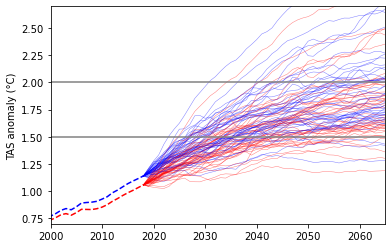

In [6]:
plt.plot(Obs_df['year'], Obs_df['world_tas'], c='blue', 
         linestyle='--', label='Observations')
plt.plot(Obs_df['year'], Obs_df['no_arctic_tas'], c='red', 
         linestyle='--', label='Observations without AA')


for i in range(len(blues)):
    plt.plot(years[i], blues[i],
             c='b', alpha=0.5, linewidth=0.5, label='CMIP6')
    plt.plot(years[i], reds[i], 
             c='r', alpha=0.5, linewidth=0.5, label='CMIP6 without AA')


plt.xlim(2000,2065)
plt.ylim(0.7, 2.7)
plt.axhline(2, color='gray')
plt.axhline(1.5, color='gray')
plt.ylabel('TAS anomaly (°C)')
# plt.savefig(f'Figures/tas_projections_{exp}.png', dpi=300)

plt.show()


In [7]:
cols_to_keep_m_df = ['year', 'Experiment', 'Model', 'adjusted_world_tas_anom', 'adjusted_no_arctic_tas_anom']
M_df = M_df[cols_to_keep_m_df]

M_df.to_csv('Outputs/master_df_temp_projections_{r}yr_rolling_{scenario}.csv'.format(r=window, scenario=exp))
Obs_df.to_csv('Outputs/Processed_{o}_{r}yr_rolling.csv'.format(o=obs_set, r=window))

mean = str(np.round(out_df['gap'].mean(), 2))
standard_error = str(np.round(out_df['gap'].sem(), 2))
print('mean gap for crossing {}C: '.format(temp_thresh)+mean+' +- '+standard_error+' years')
out_df.to_csv('Outputs/crossing_years_adjusted_{r}yr_rolling_{e}_{t}C_thresh.csv'.format(r=window, e=exp, t=temp_thresh))
out_df

mean gap for crossing 1.5C: 7.22 +- 1.04 years


,Model,No_arctic_crossing_year,World_crossing_year,gap
0,ACCESS-CM2,2026.836,2024.915,1.921
1,ACCESS-ESM1-5,2033.724,2028.536,5.188
2,AWI-CM-1-1-MR,2050.467,2038.445,12.022
3,BCC-CSM2-MR,2035.772,2029.341,6.431
4,CAMS-CSM1-0,2055.516,2035.228,20.288
5,CAS-ESM2-0,2027.053,2024.049,3.004
6,CESM2,2028.740,2026.994,1.746
7,CESM2-WACCM,2036.262,2033.519,2.743
8,CIESM,2062.209,2035.776,26.433
9,CMCC-CM2-SR5,2040.052,2035.236,4.816


In [8]:
#plt.plot(M_df[M_df['Model'] == 'FGOALS-g3'].dropna()['year'], 
#         M_df[M_df['Model'] == 'FGOALS-g3'].dropna()['adjusted_no_arctic_tas_anom'])
#plt.xlim(2050, 2100)
#plt.ylim(1.5, 2)
#out_dfs

In [9]:
### now repeat calc with multiple ensemble members

Model = []
Ensemble_member = []
No_arctic = []
World = []
for m in models:
    m_df = tas_df[tas_df['Model']==m]
    ens_mems = m_df[m_df['Experiment']==exp]['Ensemble_member'].unique()
    #print(m)
    for e in ens_mems:
        #print(e)
    
        me_df = m_df[m_df['Ensemble_member']==e]
        me_df.sort_values(by='year', axis=0)

        me_df['rolling_world_anom'] = me_df['world_tas_anom'].rolling(window, center=True).mean()
        me_df['rolling_no_arctic_anom'] = me_df['no_arctic_tas_anom'].rolling(window, center=True).mean()

        try:
            ratio_w = (me_df[me_df['year']==obs_year]['rolling_world_anom']/global_warming_obs).values[0]
            ratio_na = (me_df[me_df['year']==obs_year]['rolling_no_arctic_anom']/no_arctic_warming_obs).values[0]
        except:
            print('error on: ' + m + e)
            
        me_df['adjusted_world_tas_anom']= (me_df['rolling_world_anom']/ratio_w)
        me_df['adjusted_no_arctic_tas_anom']= (me_df['rolling_no_arctic_anom']/ratio_na)
        
        no_arctic_crossing_year = np.interp(temp_thresh, me_df['adjusted_no_arctic_tas_anom'], me_df['year'])
        if np.isnan(no_arctic_crossing_year): #extrapolate
            print(m + e + ' doesnt cross {} without arctic'.format(temp_thresh))
            me_df_regress = me_df[me_df['year'] > 2080].dropna()
            regression = stats.linregress(me_df_regress['year'], me_df_regress['adjusted_no_arctic_tas_anom'])
            no_arctic_crossing_year = (temp_thresh - regression[1])/regression[0]
            print('extrapolated crossing year: {}'.format(str(no_arctic_crossing_year)))
            
        
        world_crossing_year = np.interp(temp_thresh, me_df['adjusted_world_tas_anom'], me_df['year'])
        if np.isnan(world_crossing_year): #extrapolate
            print(m + e + ' doesnt cross {}'.format(temp_thresh))
            me_df_regress = me_df[me_df['year'] > 2080].dropna()
            regression = stats.linregress(me_df_regress['year'], me_df_regress['adjusted_world_tas_anom'])
            world_crossing_year = (temp_thresh - regression[1])/regression[0]
            print('extrapolated crossing year (world): {}'.format(str(no_arctic_crossing_year)))
            
        
        Model.append(m)
        No_arctic.append(np.round(no_arctic_crossing_year,3))
        World.append(np.round(world_crossing_year,3))
        Ensemble_member.append(e)
            

out_df_ME = pd.DataFrame({'Model':Model,
                          'Ensemble_member':Ensemble_member,
                       'No_arctic_crossing_year':No_arctic,
                       'World_crossing_year':World})
out_df_ME['gap'] = out_df_ME['No_arctic_crossing_year'] - out_df_ME['World_crossing_year']

out_df_ME_all = out_df_ME.copy()
out_df_ME_all.to_csv('Outputs/Crossing_years_multi_ensemble_mems_{r}yr_rolling_{e}_{t}C_thresh.csv'.format(r=window, e=exp, t=temp_thresh))
## keep only models with more than x ensemble members:
ens_members_needed = 1
models_to_keep = []
for m in models:
    n = len(out_df_ME[out_df_ME['Model']==m])
    if n >= ens_members_needed:
        models_to_keep.append(m)

out_df_ME = out_df_ME[out_df_ME['Model'].isin(models_to_keep)]

out_df_ME.to_csv('Outputs/Crossing_years_multi_ensemble_mems_for_box_plot_{r}yr_rolling_{e}_{t}C_thresh.csv'.format(r=window, e=exp, t=temp_thresh))

FGOALS-g3r1i1p1f1 doesnt cross 1.5 without arctic
extrapolated crossing year: 2054.48326912063
FGOALS-g3r1i1p1f1 doesnt cross 1.5
extrapolated crossing year (world): 2054.48326912063
IITM-ESMr1i1p1f1 doesnt cross 1.5 without arctic
extrapolated crossing year: 2043.1026293481987
IITM-ESMr1i1p1f1 doesnt cross 1.5
extrapolated crossing year (world): 2043.1026293481987
KIOST-ESMr1i1p1f1 doesnt cross 1.5 without arctic
extrapolated crossing year: 1981.8377177389962
KIOST-ESMr1i1p1f1 doesnt cross 1.5
extrapolated crossing year (world): 1981.8377177389962
MPI-ESM1-2-LRr10i1p1f1 doesnt cross 1.5 without arctic
extrapolated crossing year: 2075.1998895913257
MPI-ESM1-2-LRr5i1p1f1 doesnt cross 1.5 without arctic
extrapolated crossing year: 2077.9134920041297
MPI-ESM1-2-LRr6i1p1f1 doesnt cross 1.5 without arctic
extrapolated crossing year: 2067.222744652207


In [10]:
len(out_df_ME.Model.unique())

45

In [23]:
models = list(set(out_df_ME['Model']))

ensemble_members = [out_df_ME[out_df_ME['Model']==model].shape[0] for model in models]

ensemble_members = [np.max(out_df_ME[out_df_ME['Model']==model]['gap']) - np.min(out_df_ME[out_df_ME['Model']==model]['gap']) for model in models]

ensemble_members = pd.DataFrame({'model':models,'members':ensemble_members})

ensemble_members = ensemble_members.sort_values('members').iloc[::-1]

vectors = [out_df_ME[out_df_ME['Model']==m]['gap'] for m in models]
means = np.array([list(v)[0] for v in vectors])

boxplot_df = pd.DataFrame({'vectors':vectors,'means':means,'models':models})

boxplot_df = boxplot_df[boxplot_df['means']>0]

boxplot_df

,vectors,means,models
0,"106 23.596 Name: gap, dtype: float64",23.596,MCM-UA-1-0
1,"10 1.746 Name: gap, dtype: float64",1.746,CESM2
2,"93 5.645 Name: gap, dtype: float64",5.645,HadGEM3-GC31-LL
3,"7 20.288 8 32.516 Name: gap, dtype: float64",20.288,CAMS-CSM1-0
4,"5 12.022 Name: gap, dtype: float64",12.022,AWI-CM-1-1-MR
5,"97 4.505 Name: gap, dtype: float64",4.505,INM-CM5-0
6,"86 5.808 Name: gap, dtype: float64",5.808,EC-Earth3-Veg-LR
7,"90 12.454 Name: gap, dtype: float64",12.454,GFDL-ESM4
8,"107 5.145 108 7.844 Name: gap, dtype: fl...",5.145,MIROC-ES2L
9,"119 26.846 120 39.262 Name: gap, dtype: ...",26.846,MPI-ESM1-2-HR


8.144666666666641


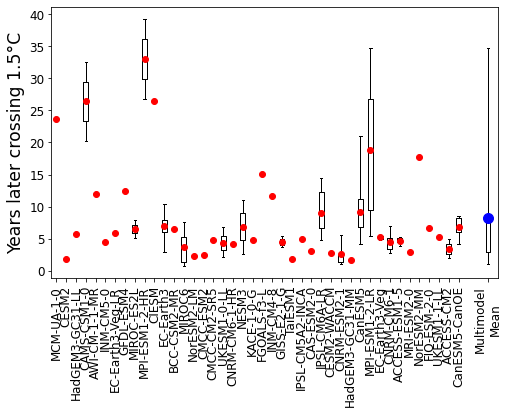

In [24]:
## plot


fig, ax = plt.subplots(1,1,figsize=(8,5))

ax.boxplot(boxplot_df['vectors'],positions=np.arange(len(boxplot_df['vectors'])),whis=[0,100],
           showmeans=True,medianprops={'linewidth':0}, vert=True,
            meanprops={'marker':'o',
              'markerfacecolor':'r',
              'markeredgecolor':'r'})

mm_shift = 2

ax.boxplot(boxplot_df['means'],positions=[len(boxplot_df['vectors'])+mm_shift],widths=0.5,
           showmeans=True,
           whis=[0,100],
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':10,
                      'markerfacecolor':'b',
                      'markeredgecolor':'b'},
          vert=True)

print(np.nanmean(boxplot_df['means']))
ax.set_xlim(-0.5,len(boxplot_df['vectors'])+mm_shift+1)
ax.set_xticklabels(list(boxplot_df['models'])+['Multimodel\nMean'],rotation=90)
ax.set_ylabel(f'Years later crossing {temp_thresh}°C',fontsize='x-large')


plt.show()

In [25]:
ordered_models = pd.DataFrame({'Model': boxplot_df['models'],
                               'Ensemble_members_count': None}).set_index('Model')
for model in ordered_models.index:
    count = len(out_df_ME[out_df_ME['Model']==model]['Ensemble_member'].unique())
    ordered_models['Ensemble_members_count'][model] = count

single_mem_models = ordered_models[ordered_models['Ensemble_members_count']==1]
multi_mem_models = ordered_models[ordered_models['Ensemble_members_count'] != 1]

#sort alphabetically for each category
single_mem_models.sort_index(inplace=True)
single_mem_models = single_mem_models[::-1]
multi_mem_models.sort_index(inplace=True)
multi_mem_models = multi_mem_models[::-1]
#recombine
ordered_models = pd.concat([multi_mem_models, single_mem_models])

#print(ordered_models)

Temp Thresh: 1.5
2038.8656666666664 2032.5275476190475 6.338119047618875 nan


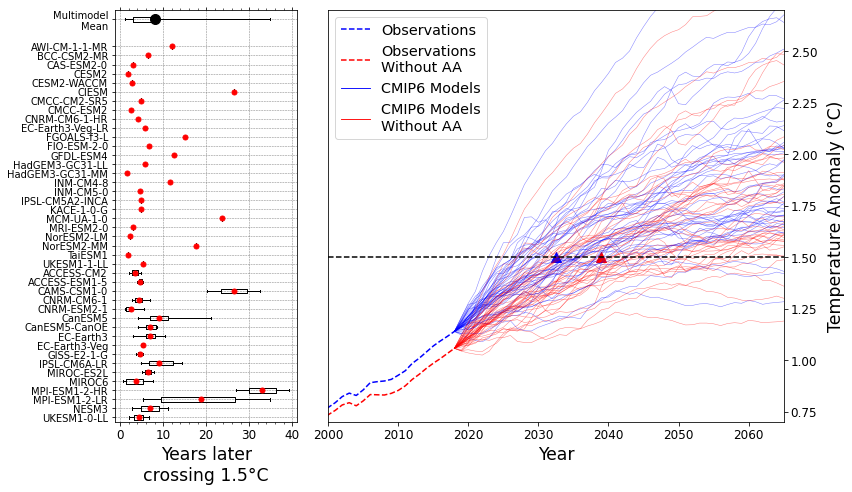

In [26]:
## combine both plots

 
#models = ensemble_members['model']
#out_df_ME.dropna(inplace=True)
vectors = [out_df_ME[out_df_ME['Model']==m]['gap'] for m in ordered_models.index]
means = np.array([list(v)[0] for v in vectors])
multi_mem_vectors = [out_df_ME[out_df_ME['Model']==m]['gap'] for m in multi_mem_models.index]
single_mem_vectors = [out_df_ME[out_df_ME['Model']==m]['gap'] for m in single_mem_models.index]


fig, (ax2, ax1) = plt.subplots(1,2,figsize=(12,7), gridspec_kw={'width_ratios': [1, 2.5]})
plt.rcParams['font.size'] = '12'

for i in range(len(blues)):
    ax1.plot(years[i], blues[i],
             c='b', alpha=0.5, linewidth=0.5)
    ax1.plot(years[i], reds[i], 
             c='r', alpha=0.5, linewidth=0.5)


## add observations:
ax1.plot(Obs_df['year'], Obs_df['world_tas'], c='blue', 
         linestyle='--', label='Observations')
ax1.plot(Obs_df['year'], Obs_df['no_arctic_tas'], c='red', 
         linestyle='--', label='Observations\nWithout AA')

# legend_without_duplicate_labels(ax1,fontsize='large')

ax1.plot([],[],lw=0.9,label='CMIP6 Models',color='b')
ax1.plot([],[],lw=0.9,label='CMIP6 Models\nWithout AA',color='r')

ax1.legend(fontsize='large')


ax1.set_xlim(2000,2065)
ax1.set_ylim(0.7, 2.7)

ax1.set_ylabel('Temperature Anomaly (°C)',fontsize='x-large', labelpad=10)
ax1.set_xlabel('Year',fontsize='x-large')
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')


###########################################

ax2.boxplot(vectors,positions=np.arange(len(vectors)),whis=[0,100],
           showmeans=True,medianprops={'linewidth':0}, vert=False,
            meanprops={'marker':'o', 
                       'markersize':5,
              'markerfacecolor':'r',
              'markeredgecolor':'r'})
mm_shift = 2
ax2.boxplot(means,positions=[len(vectors)+mm_shift],widths=0.5,
           showmeans=True,
           whis=[0,100],
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':10,
                      'markerfacecolor':'black',
                      'markeredgecolor':'black'},
          vert=False)


ax2.set_ylim(-0.5,len(vectors)+mm_shift+1)
ax2.set_xlabel(f'Years later\ncrossing {temp_thresh}°C',fontsize='x-large')

ax2.tick_params(axis="x",direction="out", which='both', top=True, labeltop=False, bottom=True, labelbottom=True)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
ax2.set_yticklabels(list(ordered_models.index)+['Multimodel\nMean'],rotation=0, fontsize='small')  

markersize=100
marker='^'

for temp_thresh in thresholds:
    
    ax1.axhline(1.5, color='k',ls='--')
    
    out_df = out_dfs[temp_thresh]
    
    x,y = np.nanmean(out_df['No_arctic_crossing_year']), np.nanmean(out_df['World_crossing_year'])
    z = stats.sem(out_df['gap'])
    ax1.scatter(x,temp_thresh,color='r',marker=marker,s=markersize)
    ax1.scatter(y,temp_thresh,color='b',marker=marker,s=markersize)
    
    print(f'Temp Thresh: {temp_thresh}')
    print(x,y,x-y,z)
    

# fig = plt.gcf()
plt.tight_layout()
plt.savefig(f'Figures/Combined_{exp}.png', dpi=300)

plt.show()

In [15]:
import glob
import os

dirs = []
var_path = "Amon/tas"
for x in glob.glob('/badc/cmip6/data/CMIP6/ScenarioMIP/*/*/ssp370/*/Amon/tas/*/latest/'):
    dirs.append(x)

print(len(dirs))

0
